In [1]:
import numpy as np
import matplotlib.pyplot as plt
import cv2
import math

from scipy.signal import hilbert
import scipy.stats as stats
from scipy.optimize import curve_fit
import matplotlib.mlab as mlab
import scipy.misc as misc
import scipy.special as sp

#jupyter notebook settings
%matplotlib inline
%config InlineBackend.print_figure_kwargs = {'dpi' : 500} #plotting pretty

## Take a look at Images

(-0.5, 825.5, 619.5, -0.5)

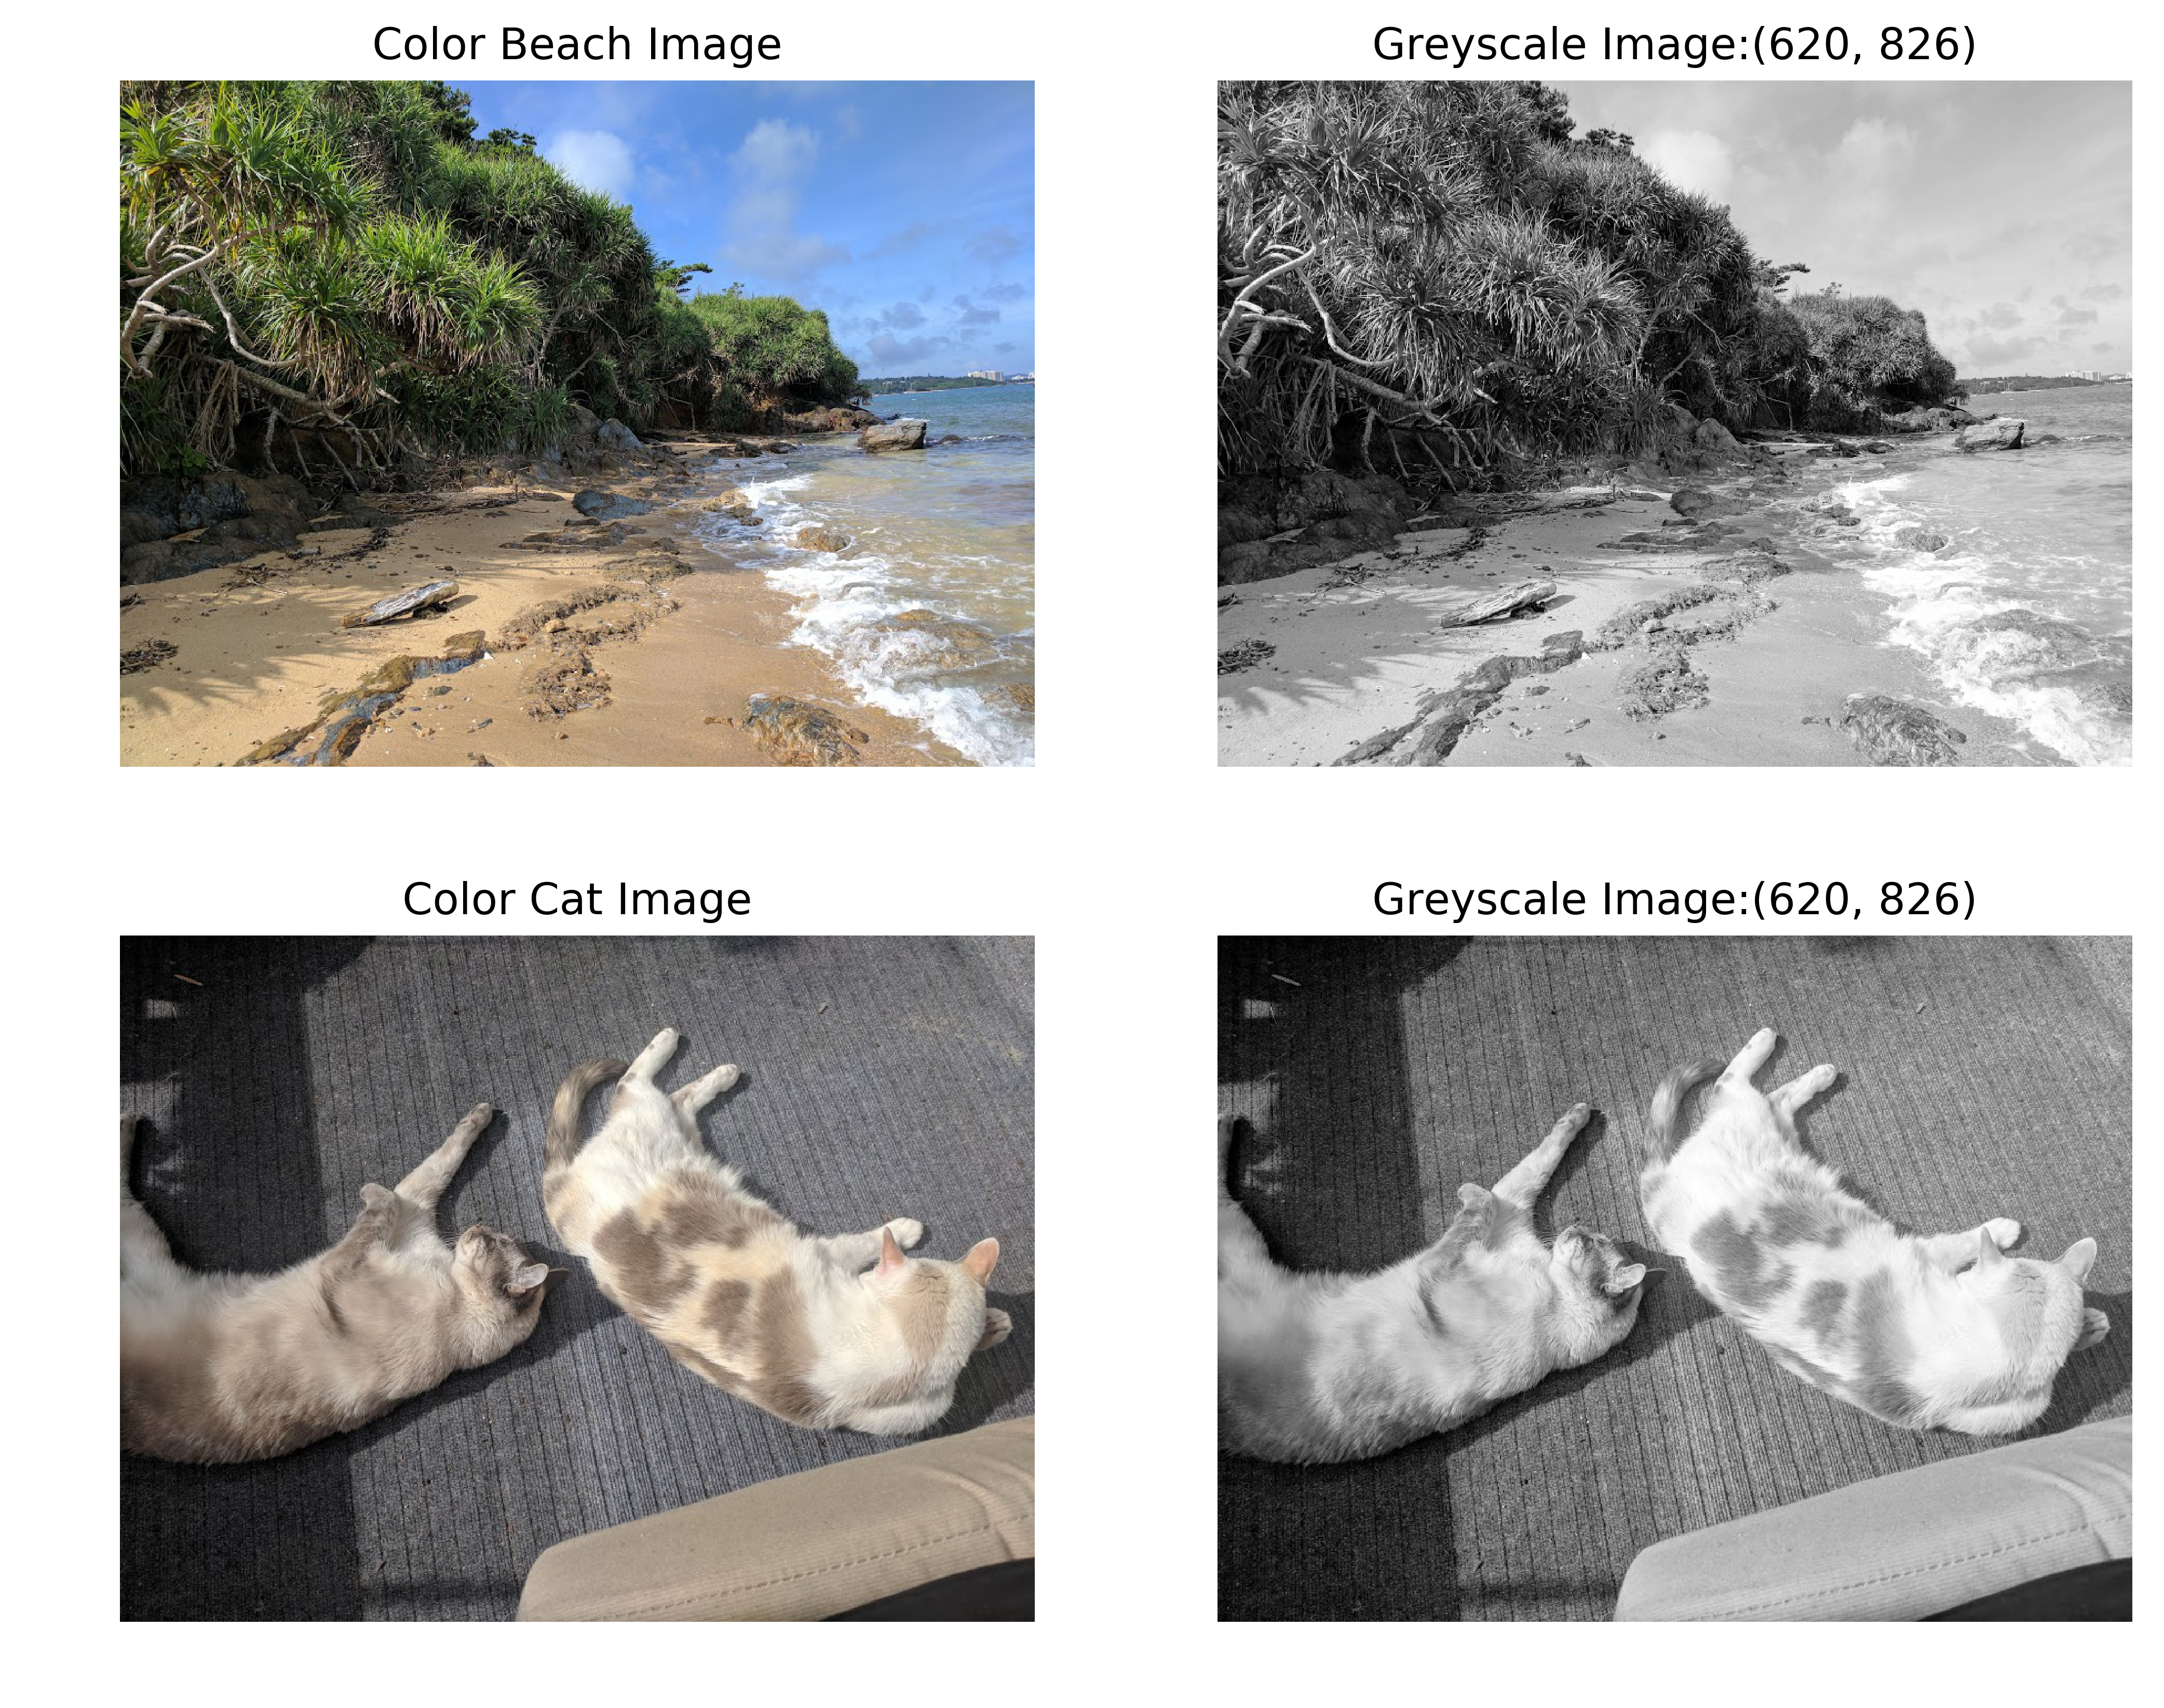

In [2]:
#Load an color image in and look at it
cbeach = cv2.imread('beach.jpg')
cbeach = cv2.cvtColor(cbeach, cv2.COLOR_BGR2RGB)
bwbeach = np.mean(cbeach,axis=2)

ccats = cv2.imread('cats.jpg')
ccats = cv2.cvtColor(ccats, cv2.COLOR_BGR2RGB)
bwcats = np.mean(ccats,axis=2)

plt.figure(figsize=(10,8))

plt.subplot(2,2,1)
plt.imshow(cbeach)
plt.title('Color Beach Image')
plt.axis('off')

plt.subplot(2,2,2)
plt.imshow(bwbeach,cmap="Greys_r")
plt.title('Greyscale Image:{}'.format(np.shape(bwbeach)))
plt.axis('off')

plt.subplot(2,2,3)
plt.imshow(ccats)
plt.title('Color Cat Image')
plt.axis('off')

plt.subplot(2,2,4)
plt.imshow(bwcats,cmap="Greys_r")
plt.title('Greyscale Image:{}'.format(np.shape(bwcats)))
plt.axis('off')


In [3]:
cats.shape

NameError: name 'cats' is not defined

## Preprocess (Cosine Window)

In [ ]:
def cosine_window(image):
    #raised cosyne window on image to avoid border artifacts
    (dim1,dim2) = np.shape(image)
    oneD = np.hanning(dim1)
    oneD = np.tile(oneD,(dim2,1)).T
    twoD = np.hanning(dim2)
    twoD = np.tile(twoD,(dim1,1))
    cosfilter = oneD*(twoD) 
    
    filtered_im = image * cosfilter
    return(filtered_im)

In [ ]:
#don't do this window right now. Too much of the image is thrown out.
beach = (bwbeach - np.mean(bwbeach))/np.mean(bwbeach)
cats = (bwcats - np.mean(bwcats))/np.mean(bwcats)

dimx = np.shape(cats)[0]
dimy = np.shape(cats)[1]

cwcats = cosine_window(cats)
cwbeach = cosine_window(beach)
# plt.figure(figsize=(10,8))

plt.subplot(1,2,1)
plt.imshow(cwbeach,cmap="Greys_r")
plt.title('Beach')
plt.axis('off')

plt.subplot(1,2,2)
plt.imshow(cwcats,cmap="Greys_r")
plt.title('Cats')
plt.axis('off')


## Get Amplitude & Phase

In [ ]:
ft_beach = np.fft.fftshift(np.fft.fft2(cwbeach))
amp_beach = np.abs(ft_beach)
angle_beach = np.angle(ft_beach)

ft_cats = np.fft.fftshift(np.fft.fft2(cwcats))
amp_cats = np.abs(ft_cats)
angle_cats = np.angle(ft_cats)

#also get frequencies
freqs_rows = np.fft.fftshift(np.fft.fftfreq(ft_cats.shape[0],d=1/ft_cats.shape[0]))
freqs_cols = np.fft.fftshift(np.fft.fftfreq(ft_cats.shape[1],d=1/ft_cats.shape[1]))

plt.figure(figsize=(8,5))

plt.subplot(2,2,1)
plt.imshow(np.log(amp_beach))
plt.title('Beach Amplitude (log)')
plt.axis('off')
plt.colorbar()

plt.subplot(2,2,3)
plt.imshow(angle_beach,cmap="hsv")
plt.title('Beach Angle')
plt.axis('off')
plt.colorbar()

plt.subplot(2,2,2)
plt.imshow(np.log(amp_cats))
plt.title('Cat Amplitude (log)')
plt.axis('off')

plt.colorbar()

plt.subplot(2,2,4)
plt.imshow(angle_cats,cmap="hsv")
plt.title('Cat Angle')
plt.axis('off')
plt.colorbar()

plt.tight_layout()

## Look at one of the angle photos, enlarged

In [ ]:
plt.figure(figsize=(10,6))
plt.imshow(angle_cats,cmap="hsv")
plt.title('Cat Angle')
plt.axis('off')
plt.colorbar()

## Look at Subset of Phase

In [ ]:
nlowphases = 30
neachside = int(nlowphases/2)

xhalf = np.int(np.shape(angle_cats)[0]/2)
yhalf = np.int(np.shape(angle_cats)[1]/2)

plt.subplot(2,2,1)
plt.imshow(angle_cats[xhalf-neachside:xhalf+neachside,:],cmap="hsv", aspect='auto')
plt.title('Cat Angle Horizontal Subset')
plt.colorbar()

plt.subplot(2,2,2)
plt.imshow(angle_cats[:,yhalf-neachside:yhalf+neachside],cmap="hsv", aspect='auto')
plt.title('Cat Angle Vertical Subset')
plt.colorbar()

plt.subplot(2,2,3)
plt.imshow(angle_beach[xhalf-neachside:xhalf+neachside,:],cmap="hsv", aspect='auto')
plt.title('Beach Angle Horizontal Subset')
plt.colorbar()

plt.subplot(2,2,4)
plt.imshow(angle_beach[:,yhalf-neachside:yhalf+neachside],cmap="hsv", aspect='auto')
plt.title('Beach Angle Vertical Subset')
plt.colorbar()

plt.tight_layout()

In [ ]:
plt.figure(figsize=(10,4))
plt.imshow(angle_cats[200:300,600:800],cmap="hsv")
plt.title('Cat Angle Subset with Structure')
plt.axis('off')
plt.colorbar()

How can we understand this? Seems there is global coherence in the phase of the lowest frequencies (these are also the ones with highest power), but this coherence persists in the joint x-low y-high frequencies, and vice versa. 

In [ ]:
plt.figure(figsize=(8,3))

plt.subplot(1,2,1)
plt.imshow(angle_cats[xhalf-neachside:xhalf+neachside,yhalf-neachside:yhalf+neachside],cmap="hsv")
plt.title('Cat Angle Subset')
plt.colorbar()

plt.subplot(1,2,2)
plt.imshow(angle_beach[xhalf-neachside:xhalf+neachside,yhalf-neachside:yhalf+neachside],cmap="hsv")
plt.title('Beach Angle Subset')
plt.colorbar()

plt.tight_layout

This is quite 'global' coherence such that it is hard to see at the local scale. With a <10x10 patch it is nearly impossible to see. 

## A few more images with different statistics to check invariances

In [ ]:
#face
face = np.mean(cv2.cvtColor(cv2.imread('face.jpg'), cv2.COLOR_BGR2RGB),axis=-1)
face = (face - np.mean(face))/np.mean(face)
face = face.T

#landscape
land = np.mean(cv2.cvtColor(cv2.imread('landscape.jpg'), cv2.COLOR_BGR2RGB),axis=-1)
land = (land - np.mean(land))/np.mean(land)

cwface = cosine_window(face)
cwland = cosine_window(land)

plt.figure(figsize=(8,4))
plt.subplot(1,2,1)
plt.imshow(face,cmap='Greys_r')
plt.title('Face')
plt.axis('off')

plt.subplot(1,2,2)
plt.imshow(land,cmap='Greys_r')
plt.title('Landscape')
plt.axis('off')

In [ ]:
ft_face = np.fft.fftshift(np.fft.fft2(cwface))
amp_face = np.abs(ft_face)
angle_face = np.angle(ft_face)

ft_land = np.fft.fftshift(np.fft.fft2(cwland))
amp_land = np.abs(ft_land)
angle_land = np.angle(ft_land)

plt.figure(figsize=(8,5))

plt.subplot(2,2,1)
plt.imshow(np.log(amp_face))
plt.title('Face Amplitude (log)')
plt.colorbar()

plt.subplot(2,2,3)
plt.imshow(angle_face,cmap="hsv")
plt.title('Face Angle')
plt.colorbar()

plt.subplot(2,2,2)
plt.imshow(np.log(amp_land))
plt.title('Land Amplitude (log)')
plt.colorbar()

plt.subplot(2,2,4)
plt.imshow(angle_land,cmap="hsv")
plt.title('Land Angle')
plt.colorbar()

plt.tight_layout()

In [ ]:
#skyline
skyline = np.mean(cv2.cvtColor(cv2.imread('skyline.jpg'), cv2.COLOR_BGR2RGB),axis=-1)
skyline = (skyline - np.mean(skyline))/np.mean(skyline)
#trail
trail = np.mean(cv2.cvtColor(cv2.imread('trail.jpg'), cv2.COLOR_BGR2RGB),axis=-1)
trail = (trail - np.mean(trail))/np.mean(trail)

cwskyline = cosine_window(skyline)
cwtrail = cosine_window(trail)

plt.figure(figsize=(8,4))
plt.subplot(1,2,1)
plt.imshow(skyline,cmap='Greys_r')
plt.title('Skyline')
plt.axis('off')

plt.subplot(1,2,2)
plt.imshow(trail,cmap='Greys_r')
plt.title('Trail')
plt.axis('off')

In [ ]:
ft_skyline = np.fft.fftshift(np.fft.fft2(cwskyline))
amp_skyline = np.abs(ft_skyline)
angle_skyline = np.angle(ft_skyline)

ft_trail = np.fft.fftshift(np.fft.fft2(cwtrail))
amp_trail = np.abs(ft_trail)
angle_trail = np.angle(ft_trail)

plt.figure(figsize=(8,5))

plt.subplot(2,2,1)
plt.imshow(np.log(amp_skyline))
plt.title('Skyline Amplitude (log)')
plt.colorbar()

plt.subplot(2,2,3)
plt.imshow(angle_skyline,cmap="hsv")
plt.title('Skyline Angle')
plt.colorbar()

plt.subplot(2,2,2)
plt.imshow(np.log(amp_trail))
plt.title('Trail Amplitude (log)')
plt.colorbar()

plt.subplot(2,2,4)
plt.imshow(angle_trail,cmap="hsv")
plt.title('Trail Angle')
plt.colorbar()

plt.tight_layout()

## Phase Distributions

In [ ]:
plt.figure(figsize=(8,3))

plt.subplot(1,2,1)
plt.hist(angle_cats.flatten())
plt.title('Cat Angle Distribution')

plt.subplot(1,2,2)
plt.hist(angle_beach.flatten())
plt.title('Beach Angle Distribution')

plt.tight_layout()

Almost a completally even distribution. What about with regards to frequency?

What if we used entropy to quantify this difference in coherence?

What if we used entropy to quantify this difference in coherence?

In [ ]:
def calc_entropy(im, rescale=True):

    #rescale 0 to 100 for binning purposes
    if(rescale):
        im = (im-min(im))/(max(im) - min(im)) * 100
    
    im = im.astype(int)
    min_val = np.min(im)
    max_val = np.max(im)

    vals = np.arange(min_val,max_val+1)
    vals_count = np.zeros_like(vals)

    #add up the occurance of each value
    for px in im:
        vals_count[px] += 1
    #normalize
    vals_prob = vals_count.astype(np.float) / np.sum(vals_count)

    #calc entropy contribution for each instance
    #some values are zero because they have probability zero. Make these zero
    vals_entropy_contrib = -1* vals_prob * np.nan_to_num(np.log(vals_prob)/np.log(2))

    #calc entropy total
    entropy = np.sum(vals_entropy_contrib)

    return(entropy)

## Phase Entropy by Radius

In [ ]:
def radial_Analysis(signal2d, func, center=None):
    """
    Calculate function of a signal for all values at a given radius.

    signal2d - 2d signal to be analyzed (not necessarily an signal_2ds)
    func - function to be applied to signal radially
    center - The [x,y] pixel coordinates used as the center. The default is 
             None, which then uses the center of the signal (including 
             fracitonal pixels).
    
    """
    # Calculate the indices from the signal_2ds
    y, x = np.indices(signal2d.shape)

    center = np.array([(x.max()-x.min())/2.0, (y.max()-y.min())/2.0])

    r = np.hypot(x - center[0], y - center[1])

    ind = np.argsort(r.flat)
    r_sorted = r.flat[ind]
    i_sorted = signal2d.flat[ind]

    # Get the integer part of the radii (bin size = 1)
    r_int = (r_sorted/1.).astype(int)

    rads = np.unique(r_int)
    vals= []
    for rad in rads:
        pxls = i_sorted[np.where(r_int == rad)]
        vals.append(func(pxls))

    #remove values larger than largest with full circle
    maxind = np.min((signal2d.shape[0]//2,signal2d.shape[1]//2))
    rads = rads[:maxind]
    vals = vals[:maxind]

    
    return(rads, vals)


In [ ]:
random_phase = np.random.rand(ft_cats.shape[0],ft_cats.shape[1])*2*np.pi - np.pi

rads, cat_vals = radial_Analysis(abs(angle_cats), calc_entropy)
rads, beach_vals = radial_Analysis(abs(angle_beach), calc_entropy)
rads, skyline_vals = radial_Analysis(abs(angle_skyline), calc_entropy)
rads, trail_vals = radial_Analysis(abs(angle_trail), calc_entropy)
rads, rand_vals = radial_Analysis(abs(random_phase), calc_entropy)


plt.figure()
plt.plot(rads, cat_vals, label='Cat Values')
plt.plot(rads, beach_vals, label='Beach Values')
plt.plot(rads, trail_vals, label='Trail Values')
plt.plot(rads, skyline_vals, label='Skyline Values')

plt.plot(rads, rand_vals, label='Random Values')
plt.legend()
# plt.gca().set_yscale("log", nonposy='clip')
plt.title('Entropy in Random Phase Angle by Frequency')

This would be a negative result. Random looks the same as images. I'm guessing because the structure does not seem to be among different directions at the same frequency, but within the same angle at all frequencies.

## Phase Entropy Among Frequencies Within Angle

In [ ]:
def direction_Analysis(signal2d, func, nbins=10, center=None):
    """
    Calculate a signal along radial profile.

    signal2d - 2d signal to be analyzed (not necessarily an signal_2ds)
    func - function to be applied to signal radially
    center - The [x,y] pixel coordinates used as the center. The default is 
             None, which then uses the center of the signal (including 
             fracitonal pixels).
    
    """
    # Calculate the indices from the signal_2ds
    y, x = np.indices(signal2d.shape)

    center = np.array([(x.max()-x.min())/2.0, (y.max()-y.min())/2.0])
    
    a = np.arctan2(( y - center[1]),(x - center[0]))
    #return(r) # can run imshow(r) to test correct

    ind = np.argsort(a.flat)
    a_sorted = a.flat[ind]
    i_sorted = signal2d.flat[ind]

    #digitize cleanly
    linbins = np.linspace(-np.pi,np.pi,nbins+1)
    a_digitized = np.take(linbins,np.digitize(a_sorted,linbins,right=True))

    #digitize by int
    # Get the integer part of the angle (bin size = 1)
    #a_digitized = a_sorted.astype(int)

    angs = np.unique(a_digitized)
    vals= []
    for ang in angs:
        #print(ang)
        pxls = i_sorted[np.where(a_digitized == ang)]
        #print(pxls)
        vals.append(func(pxls))

    return(angs, vals)


catangles, catentropy = direction_Analysis(angle_cats, calc_entropy)
beachangles, beachentropy = direction_Analysis(angle_beach, calc_entropy)
trailangles, trailentropy = direction_Analysis(angle_trail, calc_entropy)
skylineangles, skylineentropy = direction_Analysis(angle_skyline, calc_entropy)
randangles, randentropy = direction_Analysis(random_phase, calc_entropy)

plt.plot(catangles, catentropy,label='Cat')
plt.plot(beachangles, beachentropy,label='Beach')
plt.plot(skylineangles, skylineentropy,label='Skyline')
plt.plot(trailangles, trailentropy,label='Trail')
plt.plot(randangles, randentropy,label='Random')
plt.title('Entropy Wihin Angle Among Frequencies')
plt.legend()

Something is wrong here. Random should be even everywhere.

## Scramble Amplitude and Phase

In [ ]:
recon_beach = np.fft.ifft2(np.fft.ifftshift(amp_beach* np.exp(1j*angle_beach)))
recon_cats = np.fft.ifft2(np.fft.ifftshift(amp_cats* np.exp(1j*angle_cats)))
recon_anglebeach_ampcats = np.fft.ifft2(np.fft.ifftshift(amp_cats* np.exp(1j*angle_beach)))
recon_anglcats_ampbeach = np.fft.ifft2(np.fft.ifftshift(amp_beach* np.exp(1j*angle_cats)))

plt.figure(figsize=(10,8))

plt.subplot(2,2,1)
plt.imshow(np.real(recon_beach),cmap='Greys_r')
plt.title('Pure Beach Recon')
plt.axis('off')

plt.subplot(2,2,2)
plt.imshow(np.real(recon_cats),cmap='Greys_r')
plt.title('Pure Cats Recon')
plt.axis('off')

plt.subplot(2,2,3)
plt.imshow(np.real(recon_anglebeach_ampcats),cmap='Greys_r')
plt.title('Beach Angle, Cat Amplitude Recon')
plt.axis('off')

plt.subplot(2,2,4)
plt.imshow(np.real(recon_anglcats_ampbeach),cmap='Greys_r')
plt.title('Cat Angle, Beach Amplitude Recon')
plt.axis('off')


Looks like the classic result, with the phase component 'taking over', and defining the shape of the image much more

## Combine Phase with 1/f Amplitude

In [ ]:
f_alpha = 1.0
f_k = 1

def oneOverF(freq,alpha,k):
    freq = np.abs(freq)
    amp = k/(1+freq**alpha)
    return amp

onef_rows = np.expand_dims(oneOverF(freqs_rows, f_alpha, f_k),axis=1)
onef_cols = np.expand_dims(oneOverF(freqs_cols, f_alpha, f_k),axis=0)
amp_onef = (onef_rows @ onef_cols) # * ft_noise
random_phase = np.random.rand(ft_cats.shape[0],ft_cats.shape[1])*2*np.pi

recon_onef_rand = np.fft.ifft2(np.fft.ifftshift(amp_onef*np.exp(1j*random_phase)))

recon_onef_beach = np.fft.ifft2(np.fft.ifftshift(amp_onef*np.exp(1j*angle_beach)))
recon_onef_cats = np.fft.ifft2(np.fft.ifftshift(amp_onef*np.exp(1j*angle_cats)))

plt.figure(figsize=(8,8))

plt.subplot(2,2,1)
plt.imshow(np.log(amp_onef), cmap='Greys_r')
plt.title('1/f Amplitude Spectrum')

plt.subplot(2,2,2)
plt.imshow(np.real(recon_onef_rand),cmap='Greys_r')
plt.title('1/f Amp, Random Phase Recon')

plt.subplot(2,2,3)
plt.imshow(np.real(recon_onef_beach), cmap='Greys_r')
plt.title('Beach Angle, 1/f Amp Recon')

plt.subplot(2,2,4)
plt.imshow(np.real(recon_onef_cats), cmap='Greys_r')
plt.title('Cats Angle, 1/f Amp Recon')


In [ ]:
plt.figure(figsize=(8,3))

plt.subplot(1,2,1)
plt.imshow(np.log(amp_onef))
plt.colorbar()
plt.title('1/f amplitude spectrum (log)')

plt.subplot(1,2,2)
plt.imshow(np.log(amp_beach))
plt.colorbar()
plt.title('Beach amplitude spectrum (log)')

## Try Random Amplitude

In [ ]:
rand_noise = np.random.rand(np.shape(angle_cats)[0],np.shape(angle_cats)[1])
recon_rand_cats = np.fft.ifft2(np.fft.ifftshift(rand_noise*np.exp(1j*angle_cats)))

plt.figure(figsize=(10,5))
plt.subplot(1,2,1)
plt.imshow(np.log(rand_noise))
plt.title('Random Amplitude Spectrum (log)')
plt.colorbar()


plt.subplot(1,2,2)        
plt.imshow(np.real(recon_rand_cats),cmap='Greys_r');
plt.title('Random Amp, Cat Phase Recon')
#plt.colorbar()

## Try Constant Amplitude

In [ ]:
const_amp = np.ones((np.shape(angle_cats)[0],np.shape(angle_cats)[1]))
recon_const_cats = np.fft.ifft2(np.fft.ifftshift(const_amp*np.exp(1j*angle_cats)))

plt.figure(figsize=(10,5))
plt.subplot(1,2,1)
plt.imshow(const_amp)
plt.title('Constant Amplitude Spectrum')
plt.colorbar()


plt.subplot(1,2,2)        
plt.imshow(np.real(recon_const_cats),cmap='Greys_r');
plt.title('Constant Amp, Cat Phase Recon')
#plt.colorbar()

In [ ]:
plt.figure(figsize=(10,10))

plt.subplot(2,2,1)
plt.hist(np.log(amp_onef.flatten()));
plt.title('1/f Amplitude')
plt.subplot(2,2,2)
plt.hist(np.log(rand_noise.flatten()));
plt.title('Random Amplitude')
plt.subplot(2,2,3)
plt.hist(np.log(amp_beach.flatten()));
plt.title('Beach Amplitude')
plt.subplot(2,2,4)
plt.hist(np.log(amp_cats.flatten()));
plt.title('Cats Amplitude')

I think there is something wrong with the normalization here, which I'm guessing is why these reconstructions are barely recognizable. Maybe need to normalize them (see van der Schaff & Hateren 1995, Field 1987). Maybe if we can normalize these correctly, the reconstrution would be better.

## Try Random Phase
Do this twice. How much does the random seed affect what we see?

In [ ]:
rand_noise_1 = np.random.rand(np.shape(angle_cats)[0],np.shape(angle_cats)[1])*2*np.pi
recon_rand_phase_cats_1 = np.fft.ifft2(np.fft.ifftshift(amp_cats*np.exp(1j*rand_noise_1)))
recon_rand_phase_beach_1 = np.fft.ifft2(np.fft.ifftshift(amp_beach*np.exp(1j*rand_noise_1)))

rand_noise_2 = np.random.rand(np.shape(angle_cats)[0],np.shape(angle_cats)[1])*2*np.pi
recon_rand_phase_cats_2 = np.fft.ifft2(np.fft.ifftshift(amp_cats*np.exp(1j*rand_noise_2)))
recon_rand_phase_beach_2 = np.fft.ifft2(np.fft.ifftshift(amp_beach*np.exp(1j*rand_noise_2)))

plt.figure(figsize=(10,3))

plt.subplot(1,2,1)
plt.imshow(rand_noise_1, cmap='hsv')
plt.title('Random Phase 1')
plt.colorbar()

plt.subplot(1,2,2)
plt.imshow(rand_noise_2, cmap='hsv')
plt.title('Random Phase 2')
plt.colorbar()

plt.tight_layout()

In [ ]:
plt.figure(figsize=(8,8))

plt.subplot(2,2,1)
plt.imshow(np.abs(recon_rand_phase_beach_1),cmap='Greys_r');
plt.title('Beach Amp, Rand Phase Recon 1')
#plt.colorbar()

plt.subplot(2,2,2)
plt.imshow(np.abs(recon_rand_phase_beach_2),cmap='Greys_r');
plt.title('Beach Amp, Rand Phase Recon 2')
#plt.colorbar()

plt.subplot(2,2,3)        
plt.imshow(np.abs(recon_rand_phase_cats_1),cmap='Greys_r');
plt.title('Cat Amp, Rand Phase Recon 1')
#plt.colorbar()


plt.subplot(2,2,4)        
plt.imshow(np.abs(recon_rand_phase_cats_2),cmap='Greys_r');
plt.title('Cat Amp, Rand Phase Recon 2')
#plt.colorbar()

plt.tight_layout()

Interesting. Phase seems to have the 'structure', while amplitude holds the 'texture'

## Throw away phases for high frequency components

In [ ]:
nlowphases = 20
numbers = nlowphases*dimx + nlowphases*dimy - nlowphases**2
neachside = int(nlowphases/2)

cats_lowfq_phase = np.random.rand(np.shape(angle_cats)[0],np.shape(angle_cats)[1])*2*np.pi
cats_lowfq_phase[xhalf-neachside:xhalf+neachside,:] = angle_cats[xhalf-neachside:xhalf+neachside,:]
cats_lowfq_phase[:,yhalf-neachside:yhalf+neachside] = angle_cats[:,yhalf-neachside:yhalf+neachside]

beach_lowfq_phase = np.random.rand(np.shape(angle_beach)[0],np.shape(angle_beach)[1])*2*np.pi
beach_lowfq_phase[xhalf-neachside:xhalf+neachside,:] = angle_beach[xhalf-neachside:xhalf+neachside,:]
beach_lowfq_phase[:,yhalf-neachside:yhalf+neachside] = angle_beach[:,yhalf-neachside:yhalf+neachside]

recon_lowfq_phase_cats = np.fft.ifft2(np.fft.ifftshift(amp_cats*np.exp(1j*cats_lowfq_phase)))
recon_lowfq_phase_beach = np.fft.ifft2(np.fft.ifftshift(amp_beach*np.exp(1j*beach_lowfq_phase)))

recon_lowfq_phase_randamp_cats = np.fft.ifft2(np.fft.ifftshift(amp_onef*np.exp(1j*cats_lowfq_phase)))
recon_lowfq_phase_randamp_beach = np.fft.ifft2(np.fft.ifftshift(amp_onef*np.exp(1j*beach_lowfq_phase)))


plt.figure(figsize=(8,8))

plt.subplot(2,2,1)
plt.title('Beach Amp, {} Lowfq Phase Recon'.format(numbers))
plt.imshow(np.real(recon_lowfq_phase_beach),cmap='Greys_r');
#plt.colorbar()

plt.subplot(2,2,2)
plt.imshow(np.real(recon_lowfq_phase_cats),cmap='Greys_r');
plt.title('Cat Amp, {} Lowfq Phase Recon'.format(numbers))
#plt.colorbar()

plt.subplot(2,2,3)
plt.imshow(np.real(recon_lowfq_phase_randamp_beach),cmap='Greys_r');
plt.title('1/f Amp, {} Lowfq Phase Recon 2'.format(numbers))        

#plt.colorbar()

plt.subplot(2,2,4)       
plt.imshow(np.real(recon_lowfq_phase_randamp_cats),cmap='Greys_r');
plt.title('1/f Amp, {} Lowfq Phase Recon'.format(numbers))
#plt.colorbar()

plt.tight_layout()

This is cool that we can see structure in the images even though we are throwing out so much info. but wavelets still do better, so we haven't revolutionalized image compression. What it does tell us though that is very interesting, is that these 20 rows and 20 columns out of 800/600 have a lot of info about the image's structure in them. Are there statistical regularities in these rows/columns that are invariant in natural images?

## Local Energy & Phase Congruency for a Simple Example - A Step Function

In [ ]:
# def wrap2pi(angle):
#     anglewrapped = (angle) % (2 * np.pi) - np.pi
#     return anglewrapped

# def get_local_phase(t, w, phi):
#     local_phase = wrap2pi((t*w) + phi)
#     return(local_phase)

# def get_inst_phase(signal):
#     z = hilbert(signal)
#     inst_phase = np.unwrap(np.angle(z))

##In (Kolvesi, 2000) phase congruency is linearly related to the local energy, E, which is easier to caluclation.
def get_local_energy_1d(func):
    f = func - np.mean(func)
    h = np.imag(hilbert(f))
    energy = np.sqrt(f**2 + h**2)
    return(energy) 
    
#this function takes MUCH more compute.
def get_phase_congruency_1d(func):
    
#     ft = np.fft.fft(func)
#     freqs = np.fft.fftfreq(time)
#     global_amps = np.abs(ft)
#     global_phases = np.angle(ft)
    #local_amps = global_amps*np.exp(time*)
    energy = get_local_energy_1d(func)
    #pc_vals = energy / (func)
    pc_vals = energy / np.mean(np.abs(np.fft.fft(func)))
        
    return(pc_vals)

time = np.arange(0,1,1/100)
step_fun = np.append(np.append(np.zeros(33), np.ones(33)), -1*np.ones(34))

ft = np.fft.fft(step_fun)
fqs = np.fft.fftfreq(100,.01)
amp = np.abs(ft)
angle = np.angle(ft)

energy = get_local_energy_1d(step_fun)
pc = get_phase_congruency_1d(step_fun)

plt.figure()

plt.subplot(2,2,1)
plt.plot(time,step_fun,'.')
plt.title('Step Function')

plt.subplot(2,2,2)
plt.plot(fqs, angle,'.')
plt.title('Angle')

plt.subplot(2,2,3)
plt.plot(time, energy,'.')
plt.title('Energy')

plt.subplot(2,2,4)
plt.plot(time, pc,'.')
plt.title('Phase Congruency')

plt.tight_layout()


## Measure Phase Congruency in 2D

In [ ]:
def measure_energy_axis(img,axis):
    e = np.apply_along_axis(get_local_energy_1d, axis, img) 
    return(e)

def measure_energy_2d(img):
    
    x_e = measure_energy_axis(img,axis=0)
    y_e = measure_energy_axis(img,axis=1)
    
    e_vals = np.sum([x_e,y_e],axis=0)
    
    return(e_vals)

# def measure_pc_axis(img,axis):
#     e = np.apply_along_axis(get_phase_congruency_1d, axis, img) 
#     return(e)

def measure_pc_2d(img):
    
    #can't just divide x and y individually.
    e_vals = measure_energy_2d(img)
    
    pc_vals = e_vals / np.mean(np.abs(np.fft.fft2(img)))
    
    return(pc_vals)

energy_cats = measure_energy_2d(cats)
energy_beach = measure_energy_2d(beach)

pc_cats = measure_pc_2d(cats)
pc_beach = measure_pc_2d(beach)

In [ ]:
#redo calculations
ft_beach = np.fft.fftshift(np.fft.fft2(beach))
amp_beach = np.abs(ft_beach)
angle_beach = np.angle(ft_beach)

ft_cats = np.fft.fftshift(np.fft.fft2(cats))
amp_cats = np.abs(ft_cats)
angle_cats = np.angle(ft_cats)

ft_face = np.fft.fftshift(np.fft.fft2(face))
amp_face = np.abs(ft_face)
angle_face = np.angle(ft_face)

ft_land = np.fft.fftshift(np.fft.fft2(land))
amp_land = np.abs(ft_land)
angle_land = np.angle(ft_land)

ft_skyline = np.fft.fftshift(np.fft.fft2(skyline))
amp_skyline = np.abs(ft_skyline)
angle_skyline = np.angle(ft_skyline)

ft_trail = np.fft.fftshift(np.fft.fft2(trail))
amp_trail = np.abs(ft_trail )
angle_trail = np.angle(ft_trail )

recon_beach = np.fft.ifft2(np.fft.ifftshift(amp_beach* np.exp(1j*angle_beach)))
recon_cats = np.fft.ifft2(np.fft.ifftshift(amp_cats* np.exp(1j*angle_cats)))
recon_anglebeach_ampcats = np.fft.ifft2(np.fft.ifftshift(amp_cats* np.exp(1j*angle_beach)))
recon_anglcats_ampbeach = np.fft.ifft2(np.fft.ifftshift(amp_beach* np.exp(1j*angle_cats)))

In [ ]:
plt.figure(figsize=(10,8))

plt.subplot(2,2,1)
plt.imshow(energy_beach, cmap="Greys_r")
plt.title('Energy Beach')
plt.axis('off')
plt.colorbar()

plt.subplot(2,2,2)
plt.imshow(energy_cats, cmap="Greys_r")
plt.title('Energy Cats')
plt.axis('off')
plt.colorbar()

plt.subplot(2,2,3)
plt.imshow(pc_beach, cmap="Greys_r")
plt.title('PC Beach')
plt.axis('off')
plt.colorbar()

plt.subplot(2,2,4)
plt.imshow(pc_cats, cmap="Greys_r")
plt.title('PC Cats')
plt.axis('off')
plt.colorbar()

## Threshodl Phase Congruency for Edge Detection

In [ ]:
def set_thresh(m,tmin=0.3):
    #thresh = np.max(m.flatten()) - np.mean(m.flatten())
    thresh = tmin*np.max(m.flatten())
    supra_threshold_indices = m < thresh
    mthresh = np.ones_like(m)
    mthresh[supra_threshold_indices] = 0
    return(mthresh)

energy_beach_thresh = set_thresh(energy_beach)
energy_cats_thresh = set_thresh(energy_cats)

plt.figure(figsize=(8,6))

plt.subplot(2,2,1)
plt.hist(energy_beach.flatten(),log="y", bins=100)
plt.title('Beach Energy')

plt.subplot(2,2,2)
plt.hist(energy_beach_thresh.flatten(), log="y", bins=100)
plt.title('Beach Energy Thresholded')

plt.subplot(2,2,3)
plt.hist(energy_cats.flatten(), log="y", bins=100)
plt.title('Cats Energy')

plt.subplot(2,2,4)
plt.hist(energy_cats_thresh.flatten(), log="y", bins=100)
plt.title('Cats Energy Thresholded')

plt.tight_layout()

woah!!! Structure!!!

In [ ]:
plt.figure(figsize=(8,3))

plt.subplot(1,2,1)
plt.imshow(energy_beach_thresh,cmap="Greys_r")
plt.title('Thresholded Energy Beach')
plt.colorbar()

plt.subplot(1,2,2)
plt.imshow(energy_cats_thresh,cmap="Greys_r")
plt.title('Thresholded Energy Cats')
plt.colorbar()

plt.tight_layout()

## X and Y Energy Separately

In [ ]:
energy_x_beach = measure_energy_axis(beach,axis=0)
energy_y_beach = measure_energy_axis(beach,axis=1)

energy_x_cats = measure_energy_axis(cats,axis=0)
energy_y_cats = measure_energy_axis(cats,axis=1)

plt.subplot(2,2,1)
plt.imshow(energy_x_beach,cmap='Greys_r')
plt.title('Vertical energy Beach')

plt.subplot(2,2,2)
plt.imshow(energy_y_beach,cmap='Greys_r')
plt.title('Horizontal energy Beach')

plt.subplot(2,2,3)
plt.imshow(energy_x_cats,cmap='Greys_r')
plt.title('Vertical energy Cats')

plt.subplot(2,2,4)
plt.imshow(energy_y_cats,cmap='Greys_r')
plt.title('Horizontal energy Cats')

plt.tight_layout()

In [ ]:
plt.subplot(2,2,1)
plt.hist(energy_x_beach.flatten(),log='y',bins=100)
plt.title('Vertical energy Beach: $\mu={:0.2f}$'.format(np.mean(energy_x_beach)))

plt.subplot(2,2,2)
plt.hist(energy_y_beach.flatten(),log='y',bins=100)
plt.title('Horizontal energy Beach: $\mu={:0.2f}$'.format(np.mean(energy_y_beach)))

plt.subplot(2,2,3)
plt.hist(energy_x_cats.flatten(),log='y',bins=100)
plt.title('Vertical energy Cats: $\mu={:0.2f}$'.format(np.mean(energy_x_cats)))

plt.subplot(2,2,4)
plt.hist(energy_y_cats.flatten(),log='y',bins=100)
plt.title('Horizontal energy Cats: $\mu={:0.2f}$'.format(np.mean(energy_y_cats)))
          
plt.tight_layout()

In terms of the shape, for the cosine-windowed image, they look like a linear falloff, but for the unwindowed image, they look more like a skewed Gaussian Distribution (but thetail is short). Maybe a Poisson is a better descriptor? Not sure.

Either way, the horizontal looks like it has more energy than vertical - though they numbers aren't convincing that the difference is significant.

In [ ]:
catangles, catmeanpc = direction_Analysis(pc_cats, np.mean)
beachangles, beachmeanpc = direction_Analysis(pc_beach,  np.mean)
trailangles, trailmeanpc = direction_Analysis(pc_trail,  np.mean)
skylineangles, skylinemeanpc = direction_Analysis(pc_skyline,  np.mean)
randangles, randmeanpc = direction_Analysis(pc_phase,  np.mean)

plt.plot(catangles, catemeanpc,label='Cat')
plt.plot(beachangles, beachmeanpc,label='Beach')
plt.plot(skylineangles, skylinemeanpc,label='Skyline')
plt.plot(trailangles, trailmeanpc,label='Trail')
plt.plot(randangles, randmeanpc,label='Random')
plt.title('Mean PC Wihin Angle')
plt.legend()

In [ ]:
pc_beach_thresh = set_thresh(pc_beach)
pc_cats_thresh = set_thresh(pc_cats)

plt.figure(figsize=(8,6))

plt.subplot(2,2,1)
plt.hist(pc_beach.flatten(),log="y", bins=100)
plt.title('Beach PC')

plt.subplot(2,2,2)
plt.hist(pc_beach_thresh.flatten(), log="y", bins=100)
plt.title('Beach PC Thresholded')

plt.subplot(2,2,3)
plt.hist(pc_cats.flatten(), log="y", bins=100)
plt.title('Cats PC')

plt.subplot(2,2,4)
plt.hist(pc_cats_thresh.flatten(), log="y", bins=100)
plt.title('Cats PC Thresholded')

plt.tight_layout()

woah!!! Structure!!!

In [ ]:
plt.figure(figsize=(8,3))

plt.subplot(1,2,1)
plt.imshow(pc_beach_thresh,cmap="Greys_r")
plt.title('Thresholded PC Beach')
plt.colorbar()

plt.subplot(1,2,2)
plt.imshow(pc_cats_thresh,cmap="Greys_r")
plt.title('Thresholded PC Cats')
plt.colorbar()

plt.tight_layout()

## What does Noise look like in terms of local energy spectrum?

In [ ]:
#cats phase, 1/f amplitude
#recon_onef_cats
#redo phase and angle without cosine window
ft_cwcats = np.fft.fft2(cats)

#random phase, random amplitude
random_noise = np.random.rand(np.shape(cats)[0],np.shape(cats)[1])
#cat phase 1/f amplitude
recon_onef_cats = np.real(np.fft.ifft2(np.fft.ifftshift(amp_onef*np.exp(1j*angle_cats))))
#random phase, cat amplitude
recon_rand_phase_cats_1 = np.real(np.fft.ifft2(np.fft.ifftshift(amp_cats*np.exp(1j*rand_noise_1))))
#cat phase, random amplitude
recon_rand_cats = np.real(np.fft.ifft2(np.fft.ifftshift(rand_noise*np.exp(1j*angle_cats))))
#cat recon
recon_cats = np.real(np.fft.ifft2(np.fft.fft2(cats)))
#cat original
#cats

# dopn't add cosine window in phase congruency analysis
#     random_noise = cosine_window(random_noise)
#     recon_onef_cats = np.real(np.fft.ifft2(np.fft.ifftshift(cosine_window(amp_onef)*np.exp(1j*angle_cats))))
#     recon_rand_phase_cats_1 = np.real(np.fft.ifft2(np.fft.ifftshift(amp_cats*np.exp(1j*cosine_window(rand_noise_1)))))
#     recon_rand_cats = np.real(np.fft.ifft2(np.fft.ifftshift(cosine_window(rand_noise)*np.exp(1j*angle_cats))))


plt.figure(figsize=(8,8))

plt.subplot(3,2,1)
plt.imshow(random_noise, cmap = 'Greys_r')
plt.title('Noise Energy')
plt.axis('off')

plt.subplot(3,2,2)
plt.imshow(recon_onef_cats, cmap = 'Greys_r')
plt.title('1/f Amplitude, Cat Phase Energy')
plt.axis('off')

plt.subplot(3,2,3)
plt.imshow(recon_rand_phase_cats_1, cmap = 'Greys_r')
plt.title('Random Phase Cat Amplitude Energy')
plt.axis('off')

plt.subplot(3,2,4)
plt.imshow(recon_rand_cats, cmap = 'Greys_r')
plt.title('Random Amplitude Cat Phase Energy')
plt.axis('off')

plt.subplot(3,2,5)
plt.imshow(np.real(recon_cats), cmap = 'Greys_r')
plt.title('Cats Energy Real Recon')
plt.axis('off')

plt.subplot(3,2,6)
plt.imshow(cats, cmap = 'Greys_r')
plt.title('Cats Energy Raw')
plt.axis('off')

plt.tight_layout()

In [ ]:
def fitline_hist(datavec, nbins = 1000):
    
    #fit to a log-linear curve
    
    bin_heights, bin_borders, _ = plt.hist(datavec.flatten(), bins=nbins)
    bin_centers = (bin_borders[:-1] + bin_borders[1:]) / 2 #fit to centers of bins, not edges

    fit, resid, rank, sv, rcond = np.polyfit(x=bin_centers, y=np.log(1+bin_heights), deg=1, full=True)
    m,b = fit
    resid = resid[0]
    plt.semilogy(bin_centers,
                 np.exp(m*bin_centers+ b) - 1,
                 label='fit = exp({0:0.1f}x + {1:0.1f})-1, R={2:0.1f}'.format(m, b, resid))
    plt.legend()
    plt.title('M = {0:0.1f}, B = {1:0.1f}, Residual={2:0.1f}'.format(m,b,resid))
    #plt.hist(datavec.flatten(),log="y", bins=100)

def fitgauss_hist(datavec, nbins = 1000):
    
    datavec = datavec.flatten()*10
    
    #fit to a log-linear curve
    
    bin_heights, bin_borders, _ = plt.hist(datavec, bins=nbins, label='data')
    bin_centers = (bin_borders[:-1] + bin_borders[1:]) / 2 #fit to centers of bins, not edges

#     Unnormalized Gaussian
#     mu, sig = stats.norm.fit(datavec)
#     print(mu,sig)
#     pdf_fit = stats.norm.pdf(bin_centers, mu, sig)
#     plt.plot(bin_centers, pdf_fit ,label='Gaussian: $\mu$={0:0.2f}, $\sigma$={1:0.2f}'.format(mu,sig))


    #Gaussian with support for skewness
    def gauss_skew(x, amp, mu, sigma, alpha, c):
        #normal distribution
        normpdf = (1/(sigma*np.sqrt(2*math.pi)))*np.exp(-(np.power((x-mu),2)/(2*np.power(sigma,2))))
        normcdf = (0.5*(1+sp.erf((alpha*((x-mu)/sigma))/(np.sqrt(2)))))
        return (2*amp*normpdf*normcdf + c) * np.sign(sigma)
    #make an initial guess & fit
    init_guess = [np.max(bin_heights),np.mean(datavec), np.var(datavec), 1, 1]
    fitparms, fitcov = curve_fit(gauss_skew, bin_centers, bin_heights, p0=init_guess)
    #plot
    plt.plot(bin_centers, gauss_skew(bin_centers, *fitparms),
             label='SkewGauss: $\mu={0:0.2f}, \sigma={1:0.2f}, \delta={2:0.2f}$'.format(fitparms[1],fitparms[2],fitparms[3]))

#   vanilla gaussian distribution
    def gaus(x,amp,mu,sigma):
        #multiply by sign of sigma to make sure we get a positive value
        return amp*np.exp(-(x-mu)**2/(2*sigma**2))*np.sign(sigma)
    #make an initial guess & fit
    init_guess = [np.max(bin_heights),np.mean(datavec), np.var(datavec)]
    fitparms, fitcov = curve_fit(gaus, bin_centers, bin_heights, p0 = init_guess)
    #plot
    plt.plot(bin_centers, gaus(bin_centers, *fitparms),label='Gauss: $\mu={0:0.2f}, \sigma={1:0.2f}$'.format(fitparms[1],fitparms[2]))


    plt.legend(fontsize=6)
    
#     print(init_guess)
#     print(fitparms)

#don't bother fitting poisson, it's an integer fit
    
    
#fitline_hist(pc_cats)
# plt.show()
fitgauss_hist(measure_energy_2d(beach))

In [ ]:
energy_noise = measure_energy_2d(np.real(random_noise))
energy_1f_cats = measure_energy_2d(np.real(recon_onef_cats))
energy_rand_phase_cats_amp = measure_energy_2d(np.real(recon_rand_phase_cats_1))
energy_cats_phase_rand_amp = measure_energy_2d(np.real(recon_rand_cats))
energy_cats_recon = measure_energy_2d(np.real(recon_cats))
energy_cats = measure_energy_2d(cats)


plt.figure(figsize=(8,8))

plt.subplot(3,2,1)
#plt.hist(energy_noise.flatten(),log="y", bins=100)
fitgauss_hist(energy_noise)
plt.title('Noise Energy')

plt.subplot(3,2,2)
#plt.hist(np.real(recon_onef_cats).flatten(),log="y", bins=100)
fitgauss_hist(recon_onef_cats)
plt.title('1/f Amplitude, Cat Phase Energy')

plt.subplot(3,2,3)
#plt.hist(energy_rand_phase_cats_amp.flatten(), log="y", bins=100)
fitgauss_hist(energy_rand_phase_cats_amp)
plt.title('Random Phase Cat Amplitude Energy')

plt.subplot(3,2,4)
#plt.hist(energy_cats_phase_rand_amp.flatten(), log="y", bins=100)
fitgauss_hist(energy_cats_phase_rand_amp)
plt.title('Random Amplitude Cat Phase Energy')

plt.subplot(3,2,5)
#plt.hist(energy_cats_recon.flatten(),log="y", bins=100)
fitgauss_hist(energy_cats_recon)
plt.title('Cats Energy Real Recon')

plt.subplot(3,2,6)
#plt.hist(energy_cats.flatten(),log="y", bins=100)
fitgauss_hist(energy_cats)
plt.title('Cats Energy Raw')

plt.tight_layout()

In [ ]:
#random phase, random amplitude
random_noise = np.random.rand(np.shape(beach)[0],np.shape(beach)[1])
energy_noise = measure_energy_2d(random_noise)

#beach phase, 1/f amplitude
#recon_onef_beach

#random phase, beach amplitude
recon_rand_phase_beach_1 = np.fft.ifft2(np.fft.ifftshift(amp_beach*np.exp(1j*rand_noise_1)))
energy_rand_phase_beach_amp = measure_energy_2d(np.real(recon_rand_phase_beach_1))

#beach phase, random amplitude
recon_rand_beach = np.fft.ifft2(np.fft.ifftshift(rand_noise*np.exp(1j*angle_beach)))
energy_beach_phase_rand_amp = measure_energy_2d(np.real(recon_rand_beach))

#beach phase beach amp reconstructed

#beach phase beach amp raw

plt.figure(figsize=(8,8))

plt.subplot(3,2,1)
#plt.hist(energy_noise.flatten(),log="y", bins=100)
fitgauss_hist(energy_noise)
plt.title('Random Noise Energy')

plt.subplot(3,2,2)
#plt.hist(measure_energy_2d(np.real(recon_onef_beach)).flatten(),log="y", bins=100)
fitgauss_hist(measure_energy_2d(np.real(recon_onef_beach)))
plt.title('1/f Amplitude, Beach Phase Energy')

plt.subplot(3,2,3)
#plt.hist(energy_rand_phase_beach_amp.flatten(), log="y", bins=100)
fitgauss_hist(energy_rand_phase_beach_amp)
plt.title('Random Phase Beach Amplitude Energy')

plt.subplot(3,2,4)
#plt.hist(energy_beach_phase_rand_amp.flatten(), log="y", bins=100)
fitgauss_hist(energy_beach_phase_rand_amp)
plt.title('Random Amplitude Beach Phase Energy')

plt.subplot(3,2,5)
#plt.hist(measure_energy_2d(np.real(recon_beach)).flatten(),log="y", bins=100)
fitgauss_hist(measure_energy_2d(np.real(recon_beach)))
plt.title('Random Energy Real Recon')

plt.subplot(3,2,6)
#plt.hist(measure_energy_2d(beach).flatten(),log="y", bins=100)
fitgauss_hist(measure_energy_2d(beach))
plt.title('beach Energy Raw')

plt.tight_layout()

In [ ]:
plt.figure(figsize=(8,8))

ecats = np.real(measure_energy_2d(cats))
ebeach = np.real(measure_energy_2d(beach))
eskyline = np.real(measure_energy_2d(skyline))
etrail = np.real(measure_energy_2d(trail))
eface = np.real(measure_energy_2d(face))
eland = np.real(measure_energy_2d(land))


plt.subplot(3,2,1)
#plt.hist(ecats.flatten(),log="y", bins=100)
fitgauss_hist(ecats)
plt.title('Cats Energy')

plt.subplot(3,2,2)
#plt.hist(ebeach.flatten(),log="y", bins=100)
fitgauss_hist(ebeach)
plt.title('Beach Energy')

plt.subplot(3,2,3)
#plt.hist(eskyline.flatten(),log="y", bins=100)
fitgauss_hist(eskyline)
plt.title('Skyline Energy')

plt.subplot(3,2,4)
#plt.hist(etrail.flatten(),log="y", bins=100)
fitgauss_hist(etrail)
plt.title('Trail Energy')

plt.subplot(3,2,5)
#plt.hist(eface.flatten(),log="y", bins=100)
fitgauss_hist(eface)
plt.title('Face Energy')

plt.subplot(3,2,6)
#plt.hist(eland.flatten(),log="y", bins=100)
fitgauss_hist(eland)
plt.title('Land Energy')

plt.tight_layout()

In [ ]:
#random phase, random amplitude
#random_noise = np.random.rand(np.shape(beach)[0],np.shape(beach)[1])
pc_noise = measure_energy_2d(random_noise)

#beach phase, 1/f amplitude
#recon_onef_beach

#random phase, beach amplitude
#recon_rand_phase_beach_1 = np.fft.ifft2(np.fft.ifftshift(amp_beach*np.exp(1j*rand_noise_1)))
pc_rand_phase_beach_amp = measure_pc_2d(np.real(recon_rand_phase_beach_1))

#beach phase, random amplitude
recon_rand_beach = np.fft.ifft2(np.fft.ifftshift(rand_noise*np.exp(1j*angle_beach)))
pc_beach_phase_rand_amp = measure_pc_2d(np.real(recon_rand_beach))

#beach phase beach amp reconstructed

#beach phase beach amp raw

plt.figure(figsize=(8,8))

plt.subplot(3,2,1)
#plt.hist(pc_noise.flatten(),log="y", bins=100)
fitgauss_hist(pc_noise)
plt.title('Random Noise PC')

plt.subplot(3,2,2)
fitgauss_hist(measure_pc_2d(np.real(recon_onef_beach)))
#plt.hist(measure_pc_2d(np.real(recon_onef_beach)).flatten(),log="y", bins=100)
plt.title('1/f Amplitude, Beach Phase PC')

plt.subplot(3,2,3)
fitgauss_hist(pc_rand_phase_beach_amp)
#plt.hist(pc_rand_phase_beach_amp.flatten(), log="y", bins=100)
plt.title('Random Phase Beach Amplitude PC')

plt.subplot(3,2,4)
fitgauss_hist(pc_beach_phase_rand_amp)
#plt.hist(pc_beach_phase_rand_amp.flatten(), log="y", bins=100)
plt.title('Random Amplitude Beach Phase PC')

plt.subplot(3,2,5)
fitgauss_hist(measure_pc_2d(np.real(recon_beach)))
#plt.hist(measure_pc_2d(np.real(recon_beach)).flatten(),log="y", bins=100)
plt.title('Random PC Real Recon')

plt.subplot(3,2,6)
#plt.hist(measure_pc_2d(beach).flatten(),log="y", bins=100)
fitgauss_hist(measure_pc_2d(beach))
plt.title('beach PC Raw')

plt.tight_layout()

So interseting! The real images contain intersting distributions of energy, while the images composed with noise (EVEN those with REAL phase, and even with 1/f that LOOK like the image) don't have the same distribution. Woah!

Let's now look for differences between the distributions of different image categories

In [ ]:
plt.figure(figsize=(8,8))

pccats = np.real(measure_pc_2d(cats))
pcbeach = np.real(measure_pc_2d(beach))
pcskyline = np.real(measure_pc_2d(skyline))
pctrail = np.real(measure_pc_2d(trail))
pcface = np.real(measure_pc_2d(face))
pcland = np.real(measure_pc_2d(land))


fitline_hist(pcskyline, 100)

plt.subplot(3,2,1)
fitgauss_hist(pccats)
#plt.hist(pccats.flatten(),log="y", bins=100)
plt.title('Cats PC')

plt.subplot(3,2,2)
#plt.hist(pcbeach.flatten(),log="y", bins=100)
fitgauss_hist(pcbeach)
plt.title('Beach PC')

plt.subplot(3,2,3)
#plt.hist(pcskyline.flatten(),log="y", bins=100)
fitgauss_hist(pcskyline)
plt.title('Skyline PC')

plt.subplot(3,2,4)
#plt.hist(pctrail.flatten(),log="y", bins=100)
fitgauss_hist(pctrail)
plt.title('Trail PC')

plt.subplot(3,2,5)
#plt.hist(pcface.flatten(),log="y", bins=100)
fitgauss_hist(pcface)
plt.title('Face PC')

plt.subplot(3,2,6)
#plt.hist(pcland.flatten(),log="y", bins=100)
fitgauss_hist(pcland)
plt.title('Land PC')

plt.tight_layout()

## Ideas for What to Exlplore:
(bold when done)

- **Mixing Phase & Amplitude for two images**
- Combining Image Phase w/ 1/f spectrum (Do we need to normalize this somehow, or add noise to it?) Generate with random sine waves instead?)
- **Write a Phase Congruency Function**
- **Calculate Phase Congruency in image (and look at distribution)**
- **Looks like phase is most ineteresting in low frequency components - can we throw other parts away? (This ended up being an artifact in the non cosine-windowed FT)**
- **LOCAL phase! This seems to be what is important.**
- **Look at azimuthal average of phase. Plot this with a wrapping color scheme**
- **Can we make the cosine window smaller, so more of the image is retained? ALso, for phase congruency, maybe the cosine window is not needed?**
- What is the distribution of local phase, and phases with relation to their contributing frequencies?

- Hypothesis: Natural image will have a specific distrituion of local energy (that includes high components) whereas noise will NOT. Random phase images still contain some phase congruency, so explore this.

- Use Phase Congruency instead of Energy for comparing distributions to put them all on the same axis


http://cvpr11.cecs.anu.edu.au/files/PhaseCongCVPR.pdf

# Playing with 2D FFT Phase

In [ ]:
blank_array = np.zeros([500, 500], dtype=complex)

blank_array[248, 250] = np.exp(-1j*np.pi/4)

# plt.pcolormesh(np.real(blank_array))

# plt.show()
fft_blank = np.fft.ifftshift(np.fft.ifftshift(blank_array, axes=0), axes=1)
fft_blank = np.fft.ifft2(fft_blank)


plt.pcolormesh(np.real(fft_blank))

In [ ]:
blank_array = np.zeros([500, 500], dtype=complex)

blank_array[252, 250] = np.exp(1j*np.pi/4.)

fft_blank = np.fft.ifftshift(np.fft.ifftshift(blank_array, axes=0), axes=1)
fft_blank = np.fft.ifft2(fft_blank)


plt.pcolormesh(np.real(fft_blank))